# HLAthena
### A Python package for HLA class I peptide analysis, binding prediction, and model training

## Installation

To install hlathena run: 

    git clone https://github.com/ssarkizova/hlathenav2
    cd hlathenav2
    pip install .

## Usage

#### Importing the package

In [2]:
import hlathena as ht

In [3]:
# Use below to refresh modules during development 
%load_ext autoreload
%autoreload 2

import importlib
importlib.reload(ht)

from hlathena.peptide_dataset import PeptideDataset
from sklearn import preprocessing
from hlathena import definitions
from hlathena.amino_acid_feature_map import AminoAcidFeatureMap
from hlathena.pep_encoder import PepEncoder


Next, we'll import some example data

In [4]:
import pandas as pd
import os

data_dir = 'input/'
sample_pep_file = "A0101_filtered.txt"

df = pd.read_table(os.path.join(data_dir, sample_pep_file))
pep_col = 'seq' # column containing peptide sequences
peptides = list(df[pep_col])

In [51]:
df.head()

,allele,length,seq,score,backbone_cleav,totalIntensity,hg19.kgXref.geneSymbol
0,A0101,8,ADMGHLKY,16.74,7,23600000.0,PCNA
1,A0101,8,ELDDTLKY,9.66,6,30300000.0,PPP2CA
2,A0101,8,FSDNIEFY,8.51,6,950000.0,NUP107
3,A0101,8,FTELAILY,8.76,6,39900000.0,CLTC
4,A0101,8,GLDEPLLK,9.22,6,31400000.0,HLA-DQA2


### Peptide analysis

First, we'll plot the length distribution of the peptide set.

<AxesSubplot:title={'center':'Length distribution (n=1383)'}>

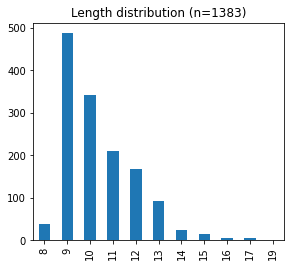

In [101]:
ht.plot_length(df)

Next, we'll visualize the amino acid motifs of this peptide set

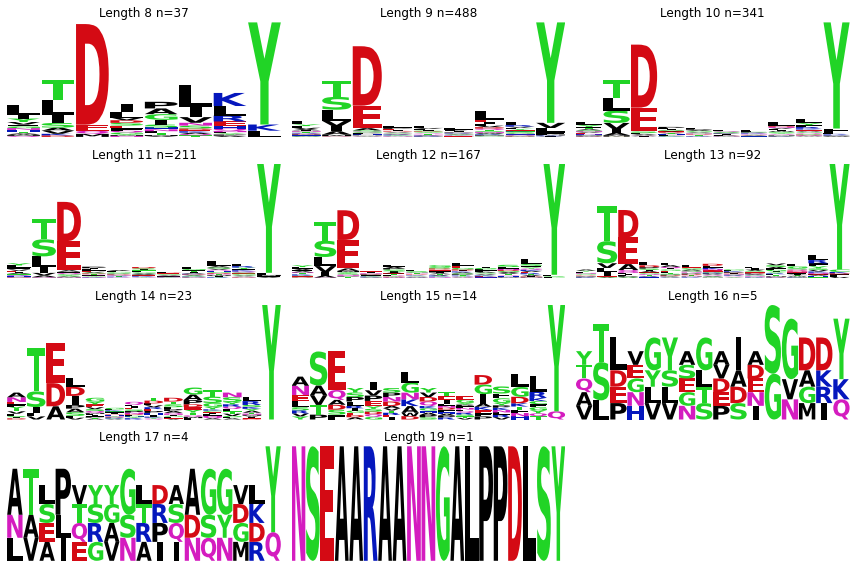

In [53]:
ht.plot_logo(df, pep_col = pep_col)

Let's examine the 9mer's motif more closely

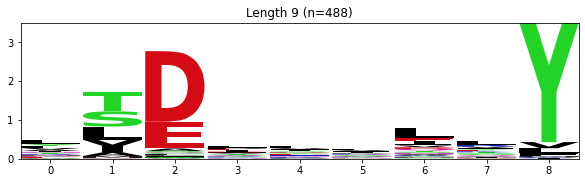

In [54]:
ht.plot_logo(df, length=9, pep_col=pep_col)

Next, we want to cluster these peptides and visualize them in 2D. First, we need to do numerically encode the peptides so that we can project them in lower dimensional space. We can do this using with peptide projection module.

We will specify that we want to use Kidera Factors for the amino acid encoding by providing a file path. Additional files with amino acid encodings can be included (they must be tab-delimited txt files with one row per amino acid symbol and 1+ columns). 

We will also save this encoding in case we want to re-use it later.

In [59]:
aa_feature_files = [os.path.join(data_dir, 'aafeatmat_KideraFactors.txt')]
aa_feature_map = ht.AminoAcidFeatureMap(aa_feature_files=aa_feature_files)

feature_matrix = ht.PCA_encode(
    peptides,     
    9, 
    allele = 'A0101', 
    aa_feature_map = aa_feature_map,
    save_PCA_path = 'pca_encoding.npz')

We can also use the default peptide encoding or other built-in encodings like so:

In [73]:
feature_matrix_default = ht.PCA_encode(
    peptides,     
    9, 
    allele = 'A0101', 
    save_PCA_path = 'pca_encoding.npz')

In [75]:
feature_matrix_builtin = ht.PCA_encode(
    peptides,     
    9, 
    allele = 'A0101', 
    aa_feature_map = ht.AminoAcidFeatureMap(
        aa_feature_files=[ht.definitions.aa_feature_file_Kidera, 
                          ht.definitions.aa_feature_file_PCA3]),
    save_PCA_path = 'pca_encoding.npz')

Now we can make a simple UMAP plot:

In [90]:
umap_embedding = ht.get_umap_embedding(feature_matrix)
#umap_embedding = ht.get_umap_embedding(feature_matrix_default)
#umap_embedding = ht.get_umap_embedding(feature_matrix_builtin)

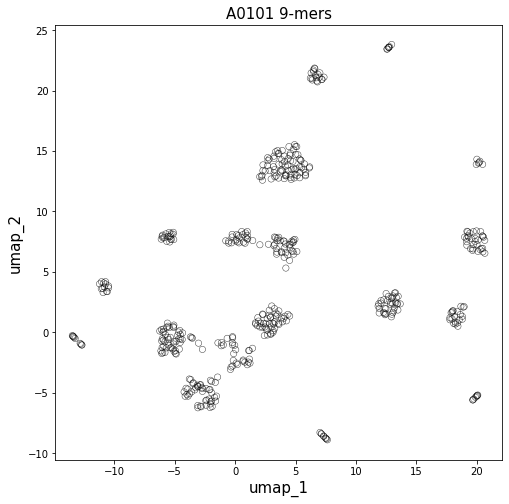

In [91]:
ht.plot_umap(umap_embedding, title='A0101 9-mers')

And we can also cluster peptides into groups, here using density based clustering (DBSCAN):

In [104]:
peptide_clustering = ht.get_peptide_clustering(
    umap_embedding,
    eps = 1)

peptide_clustering.head()

,pep,umap_1,umap_2,cluster
0,AADIFYSRY,0.197075,7.484786,8
1,AADLNLVLY,0.32515,7.395378,8
2,AADLVEALY,0.101589,7.671717,8
3,AIDEDVLRY,19.857782,7.509249,6
4,AIDLLKEIY,19.882338,7.743316,6


In [105]:
# rename as pep col
df.columns = ['allele', 'length', 'pep', 'score', 'backbone_cleav', 'totalIntensity',
       'hg19.kgXref.geneSymbol']

In [106]:
merged = peptide_clustering.merge(df, on='pep')

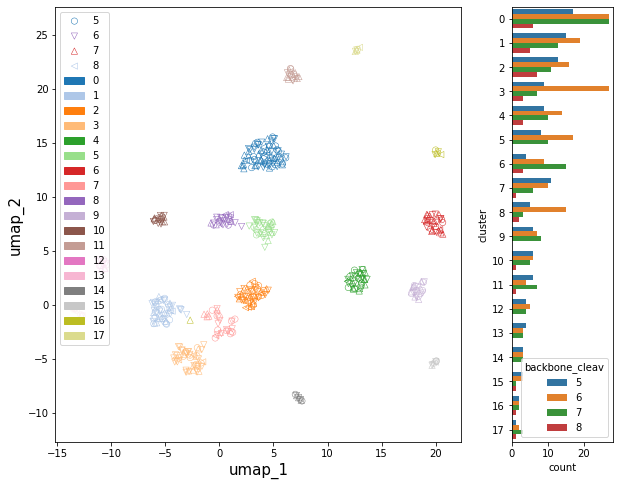

In [107]:
ht.plot_umap(
    merged, 
    clustered=True, 
    label_col='backbone_cleav')

### Annotate peptide set

In [108]:
pep_df = pd.DataFrame(peptides, columns=['seq'])
annotated_peptides = ht.get_reference_gene_ids(pep_df, add_context=True)
annotated_peptides.head()

,seq,Hugo_Symbol,ctex_up,ctex_dn
0,YSDVAKGILQY,SPATA20,HVPHFEKMLYDQAQLAVAYSQAFQLSGDEF,VARSLSHRSGGFYSAEDADSPPERGQRPK-
1,HIDFGGTSVWY,KDM7A,ENYWPDDSVFPKPFVQKYCLMGVQDSYTDF,HVLWGEKIFYLIKPTDENLARYESWSSSV-
2,YLETVAAYY,IL32,PKVLSDDMKKLKARMVMSSLAELEDDFKEG,EEQHPELTPLLEKERDGLRCRGNRSPVPD-
3,LSELFMSSFQSY,IL32,GVLAWVKEKVVALVHAVQALWKQFQSFCCS,GAPRGDKEELTPQKCSEPQSSK--------
4,HSEFLTVPAGSY,HIVEP2,LSHSSSFSMSFEREETSKLSALPKQDEFGK,SLSVPGHHHQKEMRRCSSEQMPCPHPAEV-


Next, we will annotate with TCGA reference data. In order to determine which options are available and/or the TCGA cancer type abbreviation, we call the ```list_expression_references()``` function. In this case, we will annotate with reference breast cancer expression data. 

In [18]:
ht.list_tcga_expression_references().head()

,Study Name
Study Abbreviation,
LAML,Acute Myeloid Leukemia
ACC,Adrenocortical carcinoma
BLCA,Bladder Urothelial Carcinoma
LGG,Brain Lower Grade Glioma
BRCA,Breast invasive carcinoma


 We find the relevant TCGA abbreviation and call ```add_tcga_expression```.

In [19]:
annotated_peptides = ht.add_tcga_expression(annotated_peptides, 'BRCA')

### Example GSEA Analysis

To do gene set enrichment analysis (GSEA) on this peptide set, we first create a gene/avg. sample expression matrix. In this case we will use BRCA_TPM as our sample values.



In [20]:
import gseapy as gp

c:\python3.10\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [21]:
IFN_response_genes = pd.read_table(os.path.join(data_dir, 'HALLMARK_INTERFERON_GAMMA_RESPONSE.v2023.1.Hs.txt'),header=None)
IFN_response_genes = list(IFN_response_genes[0])

In [22]:
IFNy_samples = pd.read_excel(os.path.join(data_dir, 'IFNy_sample_data/41587_2019_322_MOESM10_ESM - NBT 2019 Supp6.xlsx'), usecols=['Clinical ID','Type','Length','Peptide'])
GBM = IFNy_samples.loc[IFNy_samples['Clinical ID']=='H4198-BT187']
GBM_IFN = IFNy_samples.loc[IFNy_samples['Clinical ID']=='H4198-BT187_IFN']



In [23]:
GBM = ht.get_reference_gene_ids(GBM, pep_col='Peptide', add_context=False)
GBM_IFN = ht.get_reference_gene_ids(GBM_IFN, pep_col='Peptide', add_context=False)

We count the number of peptides from IFN response genes according to our gene annotations:

In [24]:
GSEA_GBM = gp.enrichr(gene_list=list(GBM['Hugo_Symbol']), gene_sets=['MSigDB_Hallmark_2020'], outdir='GBM_GSEA_results')
GSEA_GBM_IFN = gp.enrichr(gene_list=list(GBM_IFN['Hugo_Symbol']), gene_sets=['MSigDB_Hallmark_2020'], outdir='GBM_IFN_GSEA_results')

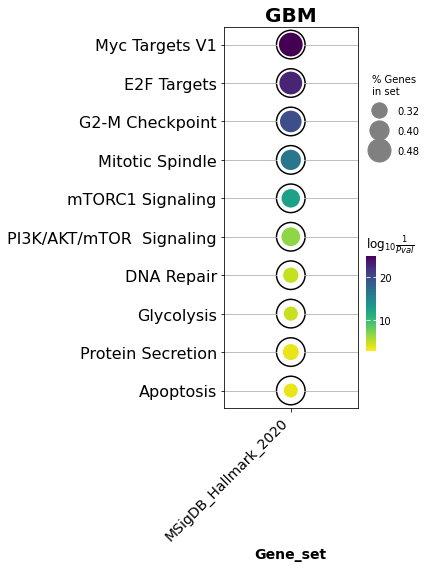

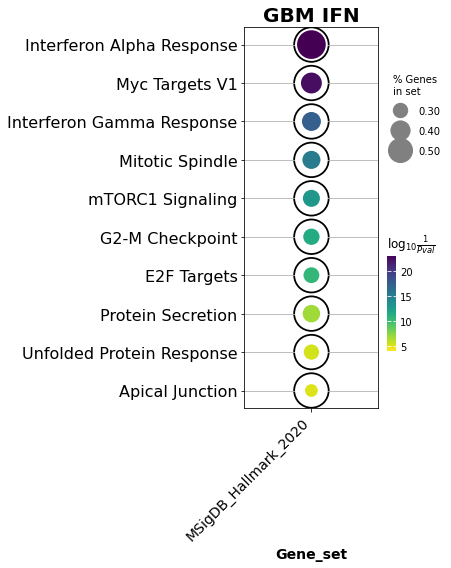

In [129]:
from gseapy import barplot, dotplot
import matplotlib.pyplot as plt

axs2 = dotplot(GSEA_GBM.results,
              column="Adjusted P-value",
              x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
              size=8,
              top_term=10,
              figsize=(3,7),
              title = "GBM",
              xticklabels_rot=45, # rotate xtick labels
              show_ring=True, # set to False to revmove outer ring
              marker='o'
             )

ax1 = dotplot(GSEA_GBM_IFN.results,
              column="Adjusted P-value",
              x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
              size=8,
              top_term=10,
              figsize=(3,7),
              title = "GBM IFN",
              xticklabels_rot=45, # rotate xtick labels
              show_ring=True, # set to False to revmove outer ring
              marker='o'              
             )


### Clustering and comparing the GBM peptides

In [130]:
GBM['label'] = 'GBM'
GBM_IFN['label'] = 'GBM_with_IFN'
full_GBM_df = pd.concat([GBM,GBM_IFN])
full_GBM_df.head()

,seq,Hugo_Symbol,label
0,LAAGHLVQL,CYP51A1,GBM
1,TMVGKTFTY,CYP51A1,GBM
2,HTSSTTSAW,CYP51A1,GBM
3,YTIPPGHQV,CYP51A1,GBM
4,GSDVVDWLY,DVL2,GBM


To make a UMAP comparison, we'll need to select a particular length. We can once again use the ```plot_length``` function to find the length distribution of the combined dataset.

<AxesSubplot:xlabel='length', ylabel='count'>

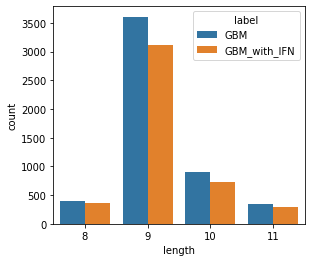

In [131]:
ht.plot_length(full_GBM_df, pep_col='seq', label_col='label')

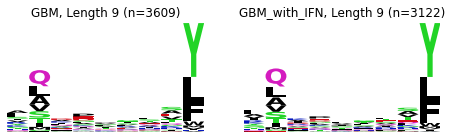

In [132]:
ht.plot_logo(full_GBM_df, length=9, pep_col='seq', label_col='label')

### Peptide binding prediction

In [5]:
model_path = '../models/NN-time2022-12-16_10-fold0.pt'

ninemers = [pep for pep in peptides if len(pep)==9] # create list of ninemers 
ht.predict(model_path, ninemers)

peptide_data.feature_dimensions 180


,seq,score
0,AADIFYSRY,3.5351831684238277e-06
1,AADLNLVLY,9.253972166334279e-06
2,AADLVEALY,9.627723329685978e-07
3,AIDEDVLRY,1.6805062841740437e-05
4,AIDLLKEIY,1.4991079524406814e-06
...,...,...
483,YTSDYFISY,0.0007096683839336038
484,YVDDVFLRV,0.953221321105957
485,YVDPQFLTY,9.512112592346966e-05
486,YVEKFALNY,1.3267766007629689e-05
